In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import torch
import wandb as wb
from ml_collections import ConfigDict
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.models.value import CriticModule
from src.dataset.dataset import OfflineRLFeatureDataset
from src.dataset.normalizer import StateActionNormalizer
from src.common.pytorch_util import dict_apply

In [3]:
api = wb.Api()
device = "cuda:0"

In [10]:
def diagnose_critic(run_id):
    # Load the config file from the run
    run = api.run(f"robot-rearrangement/critic-module-test/{run_id}")
    config = ConfigDict(run.config)

    model_wts = [file for file in run.files() if file.name.endswith(".pt")][0]
    wts_path = model_wts.download(replace=False, exist_ok=True).name

    wts_path
    # Load the model
    critic = CriticModule(
        obs_dim=config.obs_dim,
        action_dim=config.action_dim,
        obs_horizon=config.obs_horizon,
        action_horizon=config.action_horizon,
        expectile=config.expectile,
        discount=config.discount,
        critic_hidden_dims=config.critic_hidden_dims,
        critic_dropout=config.critic_dropout,
        device=device,
    )

    critic.load_state_dict(torch.load(wts_path))
    critic.eval()

    # Turn off gradients
    for param in critic.parameters():
        param.requires_grad = False
    # Load in the dataset
    dataset = OfflineRLFeatureDataset(
        dataset_path=config.data_path,
        pred_horizon=config.pred_horizon,
        obs_horizon=config.obs_horizon,
        action_horizon=config.action_horizon,
        normalizer=StateActionNormalizer(),
    )

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    end_idx = dataset.dataset["episode_ends"][0]
    end_idx
    # Set the random seed
    torch.manual_seed(69)

    # Loop over the first episode and calculate the Q-value along the trajectory
    q_values = []
    q_values_perturbed = []
    v_values = []

    obs_pert = 1
    action_pert = 2

    it = iter(loader)
    for i in trange(end_idx):
        batch = dict_apply(next(it), lambda x: x.to(device, non_blocking=True))

        # Calculate the Q-value
        nobs = critic._training_obs(batch["curr_obs"])
        naction = critic._flat_action(batch["action"])
        q_values.append(critic.q_value(nobs, naction).item())

        # Calculate the Q-value with perturbed action
        q_values_perturbed.append(
            critic.q_value(
                nobs + torch.rand_like(nobs) * obs_pert,
                naction + torch.rand_like(naction) * action_pert,
            ).item()
        )

        # Calculate the V-value
        v_values.append(critic.value(nobs).item())
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    for ax in axs:
        # Plot the Q-values
        ax.plot(q_values, label="Q-values")
        ax.plot(q_values_perturbed, label="Q-values (perturbed)")
        ax.plot(v_values, label="V-values")

        ax.set_xlabel("Time Step")

    axs[0].set_ylabel("Value")
    axs[0].legend()
    axs[1].set_ylim([-0.01, 0.05])

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 590/590 [00:06<00:00, 89.52it/s] 


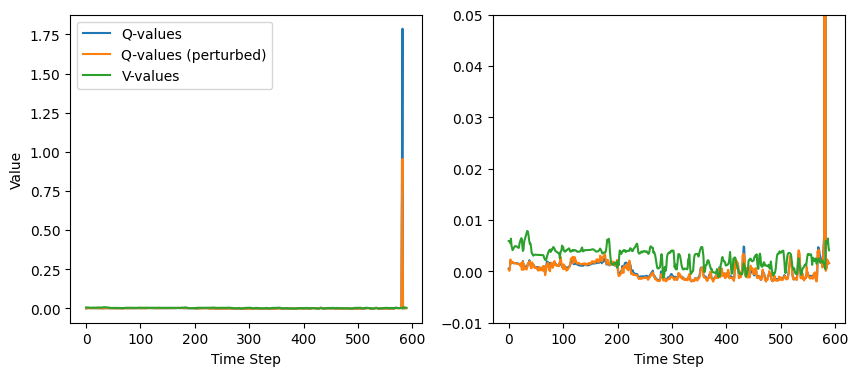

In [11]:
diagnose_critic(run_id="z7cvny7q")

## Make a dataset with only the last $n$ timesteps of each trajetory

In [11]:
n_timesteps = 32

In [12]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_orig = dataset.dataset

zarr_new = zarr.open("data_short.zarr", mode="w")

for key in tqdm(list(zarr_orig.keys())):
    # For each key, copy all the meta data for the dataset but not the data itself
    zarr_new.create_dataset(
        key, shape=(0,) + zarr_orig[key].shape[1:], dtype=zarr_orig[key].dtype
    )

In [13]:
# Loop over the episode ends and copy over the data from n before the end to the end for each key
curr_idx = 0
for i in trange(len(zarr_orig["episode_ends"])):
    end_idx = zarr_orig["episode_ends"][i]
    start_idx = end_idx - n_timesteps
    zarr_new["episode_ends"].append([curr_idx := curr_idx + n_timesteps])

    for key in ["action", "feature1", "feature2", "reward", "robot_state"]:
        zarr_new[key].append(zarr_orig[key][start_idx:end_idx])

100%|██████████| 699/699 [05:01<00:00,  2.32it/s]


## Run diagnostics on the resulting Critic from the short dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 32/32 [00:00<00:00, 131.29it/s]


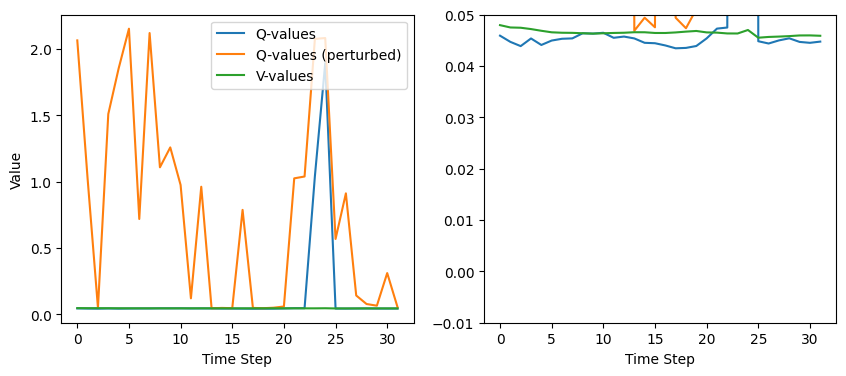

In [12]:
diagnose_critic(run_id="pskuazec")